In [1]:
import sys
sys.path.insert(0, '../')

from interface import get_query_emb_batch, load_model, cosine_similarity_batch

from typing import Tuple, List, Dict, Union, Any

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import torch

In [2]:
# pth_models = "/home/sondors/Documents/price/BERT_data/data/10-04-2024_Timofey/2801_models_Apple.csv"
pth_models = "/home/sondors/Documents/price/BERT_data/data/14-06-2024_2801_Samsung_split/models_Samsung/models_Samsung.csv"
df_models = pd.read_csv(pth_models, sep=';')

pth_offers = '/home/sondors/Documents/price/BERT_data/data/14-06-2024_2801_Samsung_split/offers_Samsung/2801_Samsung_offers_test.csv'
df_offers = pd.read_csv(pth_offers, sep=';')

id_category = {
    # 3902: 'диктофоны, портативные рекордеры',
    # 510402: 'электронные книги',
    # 4302: 'автомобильные телевизоры, мониторы',
    # 2815: 'смарт-часы и браслеты',
    # 3901: 'портативные медиаплееры',
    # 3904: 'портативная акустика',
    2801: 'мобильные телефоны',
    # 3908: 'VR-гарнитуры (VR-очки, шлемы, очки виртуальной реальности, FPV очки для квадрокоптеров)',
    # 510401: 'планшетные компьютеры и мини-планшеты',
    # 2102: 'наушники, гарнитуры, наушники c микрофоном',
    # 3903: 'радиоприемники, радиобудильники, радиочасы',
    # 3907: 'магнитолы',
    # 280801: 'GPS-навигаторы'
    }

df_models = df_models[df_models['category_id'].isin(id_category.keys())].reset_index(drop=True)
df_offers = df_offers[df_offers['category_id'].isin(id_category.keys())].reset_index(drop=True)

models = list(df_models['full_name'])
offers = list(df_offers['name'])

df_offers

,name,model_id,offer_id,modelized_by_barcode,category_name,category_id,price,attrs,description,external_category,external_brand,external_type
0,Samsung Galaxy A03 32GB Красный,8137048,1527975626,True,мобильные телефоны,2801,8490.0,"[{'id': 14523, 'type': 'b', 'value': 1.0}, {'i...",NaN,Мобильные телефоны :: Samsung,Samsung,NaN
1,Смартфон Samsung Galaxy A03 3/32Gb Красный,8137048,1523857366,True,мобильные телефоны,2801,5990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",По вопросам гарантийного обслуживания необходи...,Смартфоны :: Samsung,Samsung,Смартфон
2,Samsung Galaxy A03 32GB Синий,8137049,1542552649,True,мобильные телефоны,2801,8490.0,"[{'id': 14522, 'type': 'b', 'value': 1.0}, {'i...",NaN,Мобильные телефоны :: Samsung,Samsung,NaN
3,"Смартфон Samsung Galaxy A03 3/32 ГБ RU, синий",8137049,1485546263,False,мобильные телефоны,2801,10899.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...","Смартфон Samsung Galaxy A03 3/32 ГБ RU, синий","Смартфоны, приставки и гироскутеры :: Смартфон...",Samsung,Смартфон
4,Samsung Galaxy A03 32GB Черный,8137050,1521204872,True,мобильные телефоны,2801,8490.0,"[{'id': 14517, 'type': 'b', 'value': 1.0}, {'i...",NaN,Мобильные телефоны :: Samsung,Samsung,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1871,Смартфон Samsung Galaxy Z Fold5 5G 12/512Gb Beige,8137817,1912214576,True,мобильные телефоны,2801,173790.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...","Смартфон складной, с двумя экранами. Есть разб...",Электроника :: Мобильные телефоны и аксессуары...,Samsung,Смартфон
1872,"Смартфон Samsung Galaxy Z Fold 5 5G 12/512Gb, ...",8137818,1864973826,True,мобильные телефоны,2801,159990.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...","ОС Android 13, GPS, с защитой от пыли и влаги,...",Смартфоны и планшеты :: Смартфоны,SAMSUNG,NaN
1873,Смартфон Samsung Galaxy Z Fold 5 5G Dual (F946...,8137818,1835908073,True,мобильные телефоны,2801,114989.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Смартфон Samsung Galaxy Z Fold5 512GB имеет вы...,Fold 4,Samsung,Смартфон
1874,Смартфон Samsung Galaxy Z Fold 5 5G 12/512Gb B...,8137819,1874617580,True,мобильные телефоны,2801,154070.0,"[{'id': 3, 'type': 'e', 'value': 676.0}, {'id'...",Смартфон Samsung Galaxy Z Fold 5 5G 12/512Gb B...,Смартфоны и гаджеты :: Смартфоны,Samsung,Смартфон


In [3]:
df_models

,model_id,average_price,name,brand_name,full_name,comment,category_name,category_id
0,8137040,12168.0,"Galaxy A01 2/16Gb, черный",Samsung,"Samsung Galaxy A01 2/16Gb, черный",NaN,мобильные телефоны,2801
1,8137041,5990.0,"Galaxy A01 Core 1/16Gb, black",Samsung,"Samsung Galaxy A01 Core 1/16Gb, black",NaN,мобильные телефоны,2801
2,8137042,6290.0,"Galaxy A02 2/32Gb, красный",Samsung,"Samsung Galaxy A02 2/32Gb, красный",NaN,мобильные телефоны,2801
3,8137043,6290.0,"Galaxy A02 2/32Gb, синий",Samsung,"Samsung Galaxy A02 2/32Gb, синий",NaN,мобильные телефоны,2801
4,8137044,4390.0,"Galaxy A02 2/32Gb, черный",Samsung,"Samsung Galaxy A02 2/32Gb, черный",NaN,мобильные телефоны,2801
...,...,...,...,...,...,...,...,...
765,8159815,25890.0,"Galaxy A52 6/128Gb, синий",Samsung,"Samsung Galaxy A52 6/128Gb, синий",NaN,мобильные телефоны,2801
766,8159816,32690.0,"Galaxy A52 8/128Gb, черный",Samsung,"Samsung Galaxy A52 8/128Gb, черный",NaN,мобильные телефоны,2801
767,8159817,18800.0,"Galaxy A32 4/128Gb, черный",Samsung,"Samsung Galaxy A32 4/128Gb, черный",NaN,мобильные телефоны,2801
768,8159818,18800.0,"Galaxy A32 4/128Gb, голубой",Samsung,"Samsung Galaxy A32 4/128Gb, голубой",NaN,мобильные телефоны,2801


In [4]:
# ckpt_pth = "/home/sondors/Documents/ColBERT_weights/triples_X1_13_categories_use_ib_negatives/none/2024-01/26/10.49.44/checkpoints/colbert-5387-finish"
# experiment = "colbert-5387"

ckpt_pth = "/home/sondors/2801_lr04_bsize_210_samsung/none/2024-06/17/07.43.04/checkpoints/colbert-51-finish"
experiment = "colbert-51-finish"

doc_maxlen = 300
nbits = 2   # bits определяет количество битов у каждого измерения в семантическом пространстве во время индексации
nranks = 1  # nranks определяет количество GPU для использования, если они доступны
kmeans_niters = 4 # kmeans_niters указывает количество итераций k-means кластеризации; 4 — хороший и быстрый вариант по умолчанию. 

device = "cuda"


In [5]:
checkpoint = load_model(ckpt_pth, doc_maxlen, nbits, kmeans_niters, device)

In [6]:
offer_embs = get_query_emb_batch(offers, checkpoint, batch_size=1000, batch_size2=10000)

batch: 1876/1876


In [7]:
len(offers)

1876

In [8]:
model_embs = get_query_emb_batch(models, checkpoint, batch_size=1000, batch_size2=10000)


batch: 770/770


In [9]:
def top_n_similar(offer_embs: List[np.ndarray], model_embs: List[np.ndarray], model_ids: List[int], batch_size: int = 1000, n: int = 5) -> List[Dict[str, Union[List[int], np.ndarray]]]:
    """
    Find the top N similar embeddings for each offer embedding.

    Args:
        offer_embs (List[np.ndarray]): List of offer embeddings.
        model_embs (List[np.ndarray]): List of model embeddings.
        model_ids (List[int]): List of model IDs corresponding to model embeddings.
        batch_size (int, optional): Batch size for chunking the offer embeddings. Defaults to 1000.
        n (int, optional): Number of top similar embeddings to retrieve. Defaults to 5.

    Returns:
        List[Dict[str, Union[List[int], np.ndarray]]]: A list of dictionaries containing model IDs and their 
        corresponding cosine similarity scores for the top N similar embeddings for each offer embedding.

    Example:
        >>> offer_embeddings = [np.array([0.1, 0.2, 0.3]), np.array([0.4, 0.5, 0.6])]
        >>> model_embeddings = [np.array([0.2, 0.3, 0.4]), np.array([0.5, 0.6, 0.7])]
        >>> model_ids = [123, 456]
        >>> print(top_n_similar(offer_embeddings, model_embeddings, model_ids))
            # Output: [{'model_ids': [123, 456], 'cosine_sims': array([0.99258333, 0.96832966])},
            {'model_ids': [456, 123], 'cosine_sims': array([0.99964575, 0.99461155])}]
    """

    cosine_sims = cosine_similarity_batch(offer_embs, model_embs, batch_size)
    top_n_list = []
    for i in range(len(offer_embs)):
        # Find the indices of the top N similar embeddings
        top_n_indices = np.argsort(cosine_sims[i])[::-1][:n]
        # Get the corresponding model IDs and cosine similarity scores for the top N similar embeddings
        top_n_model_ids = [model_ids[i] for i in top_n_indices]
        top_n_cosine_sims = cosine_sims[i][top_n_indices]
        top_n_list.append({"model_ids": top_n_model_ids, "cosine_sims": top_n_cosine_sims})
    return top_n_list

In [10]:
import time
    
def emb_to_df(df, embs, imya_kategorii):
    df = df[df.category_name == imya_kategorii]
    embed_name = []
    for index, row in df.iterrows():
        embed_name.append(embs[index])
    return embed_name

def top_n_to_df(df, indices, top_n, n):
    for idx, insert_dict in zip(indices, top_n):
        for i in range(n):
            col_model_id = f'model_id_pred_{i+1}'
            col_similarity = f'cosine_sims_{i+1}'
            df.loc[idx, col_model_id] = insert_dict['model_ids'][i]
            df.loc[idx, col_similarity] = round(float(insert_dict['cosine_sims'][i]), 5)
    return df

def inference_category(df_offers, df_models, imya_kategorii, models_embs, offers_embs):
    print(f"{imya_kategorii}")
    start_time = time.time()
    df_models = df_models[df_models.category_name == imya_kategorii]

    offer_embs = emb_to_df(df_offers, offers_embs, imya_kategorii)

    model_embs = emb_to_df(df_models, models_embs, imya_kategorii)
    model_model_id = list(df_models['model_id'])

    print(f"\tофферов {len(offer_embs)} шт поиск матча для каждого среди {len(model_model_id)} шт моделей")

    batch_size = max((1, (5000*4000)//len(model_model_id)))
    top_n = top_n_similar(offer_embs, model_embs, model_model_id, batch_size, n=5)
    # offer_model_id_predicted = [i['model_ids'][0] for i in top_n]
    # cos_sims = [i['cosine_sims'][0] for i in top_n]
    indices = tuple(df_offers.index)
    df_offers = top_n_to_df(df_offers, indices, top_n, 5)
    print(f"time_spent = {round(time.time() - start_time, 2)} sec\n")
    return df_offers


for category in id_category.values():
    df_offers = inference_category(df_offers, df_models, category, model_embs, offer_embs)

мобильные телефоны
	офферов 1876 шт поиск матча для каждого среди 770 шт моделей
time_spent = 1.63 sec



In [11]:
dict(df_offers.iloc[0])

{'name': 'Samsung Galaxy A03 32GB Красный',
 'model_id': 8137048,
 'offer_id': 1527975626,
 'modelized_by_barcode': True,
 'category_name': 'мобильные телефоны',
 'category_id': 2801,
 'price': 8490.0,
 'attrs': "[{'id': 14523, 'type': 'b', 'value': 1.0}, {'id': 25534, 'type': 'e', 'value': 714.0}]",
 'description': nan,
 'external_category': 'Мобильные телефоны :: Samsung',
 'external_brand': 'Samsung',
 'external_type': nan,
 'model_id_pred_1': 8137048.0,
 'cosine_sims_1': 0.92498,
 'model_id_pred_2': 8137047.0,
 'cosine_sims_2': 0.82578,
 'model_id_pred_3': 8137050.0,
 'cosine_sims_3': 0.8249,
 'model_id_pred_4': 8137058.0,
 'cosine_sims_4': 0.78955,
 'model_id_pred_5': 8137056.0,
 'cosine_sims_5': 0.75077}

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def thresholds_accuracies_part(thresholds, accuracies, part, x_start=0, x_stop=1.001, x_step=0.025):
    """
    Визуализирует зависимость точности и части от общего числа строк 
    от порога cosine_sims_1 на двух подграфиках.

    Параметры:
    - thresholds: список порогов cosine_sims_1
    - accuracies: список значений точности
    - part: список значений части от общего числа строк
    - x_start: начальное значение по оси X
    """
    filtered_thresholds = [t for t in thresholds if t >= x_start]
    filtered_accuracies = accuracies[len(thresholds) - len(filtered_thresholds):]
    filtered_part = part[len(thresholds) - len(filtered_thresholds):]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(filtered_thresholds, filtered_accuracies, marker='.', label='Accuracy')
    ax1.set_title('Зависимость точности от порога cosine_sims_1')
    ax1.set_xlabel('Порог cosine_sims_1')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True)

    ax1.set_xticks(np.arange(x_start, x_stop, x_step))

    # Построение второго графика (часть от общего числа строк)
    ax2.plot(filtered_thresholds, filtered_part, marker='.', color='orange', linestyle='dashed', label='Часть от общего числа строк')
    ax2.set_title('Зависимость части от общего числа строк от порога cosine_sims_1')
    ax2.set_xlabel('Порог cosine_sims_1')
    ax2.set_ylabel('Часть от общего числа строк')
    ax2.grid(True)

    ax2.set_xticks(np.arange(x_start, x_stop, x_step))

    plt.tight_layout()
    plt.show()

def accuracies_part(accuracies, part, x_start=0, x_stop=1.001, x_step=0.025):
    """
    Визуализирует зависимость точности и части от общего числа строк 
    на одном графике.

    Параметры:
    - accuracies: список значений точности
    - part: список значений части от общего числа строк
    """
    filtered_accuracies = [t for t in accuracies if t >= x_start]
    filtered_part = part[len(part) - len(filtered_accuracies):]
    plt.figure(figsize=(8, 6))

    plt.plot(filtered_accuracies, filtered_part, marker='.', color='orange', linestyle='dashed', label='Accuracy vs. Part')
    plt.title('Зависимость точности от части от общего числа строк')
    plt.xlabel('Accuracy')
    plt.ylabel('Часть от общего числа строк')
    plt.grid(True)

    plt.xticks(np.arange(x_start, x_stop, x_step))

    plt.tight_layout()
    plt.show()

def plot_threshold_accuracies(thresholds, accuracies, x_start=0, x_stop=1.001, x_step=0.025, y_step=0.01):
    """
    Визуализирует зависимость точности от порога cosine_sims_1.

    Параметры:
    - thresholds: список порогов cosine_sims_1
    - accuracies: список значений точности
    - x_start: начальное значение по оси X
    """
    filtered_thresholds = [t for t in thresholds if t >= x_start]
    filtered_accuracies = accuracies[len(thresholds) - len(filtered_thresholds):]

    plt.figure(figsize=(8, 6))

    plt.plot(filtered_thresholds, filtered_accuracies, marker='.', label='Accuracy')
    plt.title('Зависимость точности от порога cosine_sims_1')
    plt.xlabel('Порог cosine_sims_1')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.yticks(np.arange(min(filtered_accuracies), max(filtered_accuracies), y_step))

    plt.xticks(np.arange(x_start, x_stop, x_step))

    plt.tight_layout()
    plt.show()

def plot_threshold_part(thresholds, part, x_start=0, x_stop=1.001, x_step=0.025):
    """
    Визуализирует зависимость части от общего числа строк от порога cosine_sims_1.

    Параметры:
    - thresholds: список порогов cosine_sims_1
    - part: список значений части от общего числа строк
    - x_start: начальное значение по оси X
    """
    filtered_thresholds = [t for t in thresholds if t >= x_start]
    filtered_part = part[len(thresholds) - len(filtered_thresholds):]

    plt.figure(figsize=(8, 6))

    plt.plot(filtered_thresholds, filtered_part, marker='.', color='orange', linestyle='dashed', label='Часть от общего числа строк')
    plt.title('Зависимость части от общего числа строк от порога cosine_sims_1')
    plt.xlabel('Порог cosine_sims_1')
    plt.ylabel('Часть от общего числа строк')
    plt.grid(True)

    plt.xticks(np.arange(x_start, x_stop, x_step))

    plt.tight_layout()
    plt.show()

# Подсчет accuracy в зависимости от порога cosine_sims_1
thresholds = [i/1000 for i in range(1000)]
accuracies = []
part = []
for threshold in thresholds:
    df_thersold = df_offers[df_offers['cosine_sims_1'] >= threshold]
    accurate_predictions_threshold = (df_thersold['model_id_pred_1'].astype(int) == df_thersold['model_id']).sum()
    accuracy = accurate_predictions_threshold / len(df_thersold)
    accuracies.append(accuracy)
    # part.append(len(df_thersold)/len(df))
    part.append(len(df_thersold))

# Вывод результатов
# for threshold, accuracy in zip(thresholds, accuracies):
#     print(f"Порог cosine_sims_1: {threshold}, Accuracy: {accuracy}")

/tmp/ipykernel_48727/2061037431.py:124: RuntimeWarning: invalid value encountered in long_scalars
  accuracy = accurate_predictions_threshold / len(df_thersold)


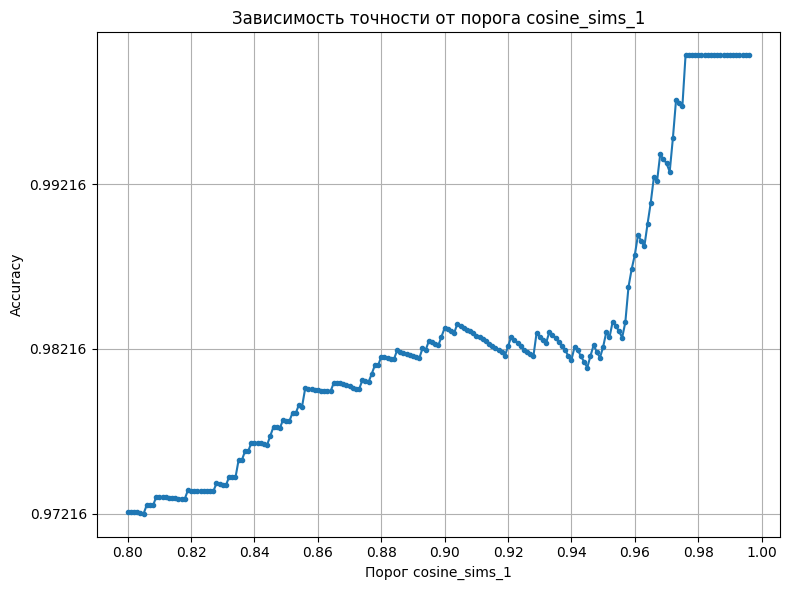

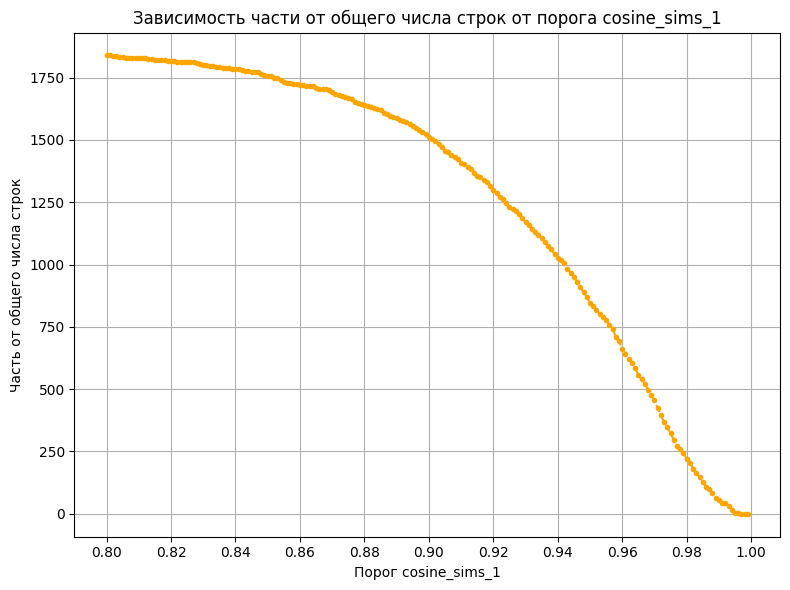

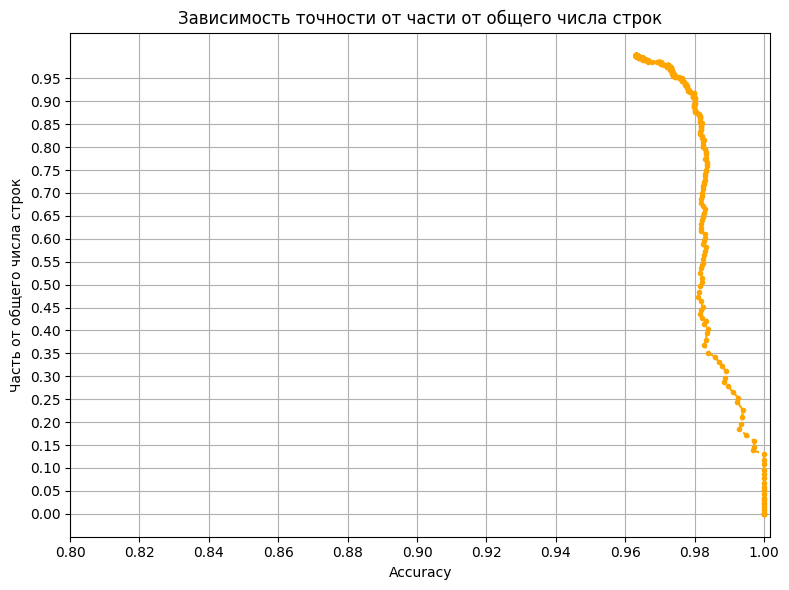

In [13]:
def accuracies_part(accuracies, part, x_start=0, x_stop=1.001, x_step=0.025):
    """
    Визуализирует зависимость точности и части от общего числа строк 
    на одном графике.

    Параметры:
    - accuracies: список значений точности
    - part: список значений части от общего числа строк
    """
    filtered_accuracies = [t for t in accuracies if t >= x_start]
    filtered_part = part[len(part) - len(filtered_accuracies):]
    plt.figure(figsize=(8, 6))

    plt.plot(filtered_accuracies, filtered_part, marker='.', color='orange', linestyle='dashed', label='Accuracy vs. Part')
    plt.title('Зависимость точности от части от общего числа строк')
    plt.xlabel('Accuracy')
    plt.ylabel('Часть от общего числа строк')
    plt.grid(True)

    plt.yticks(np.arange(min(filtered_part), max(filtered_part), 0.05))
    plt.xticks(np.arange(x_start, x_stop, x_step))

    plt.tight_layout()
    plt.show()

plot_threshold_accuracies(thresholds, accuracies, x_start=0.8, x_stop=1.001, x_step=0.02, y_step=0.01)
plot_threshold_part(thresholds, part, x_start=0.8, x_stop=1.001, x_step=0.02)
accuracies_part(accuracies, [i/len(df_offers) for i in part], x_start=0.8, x_stop=1.001, x_step=0.02)

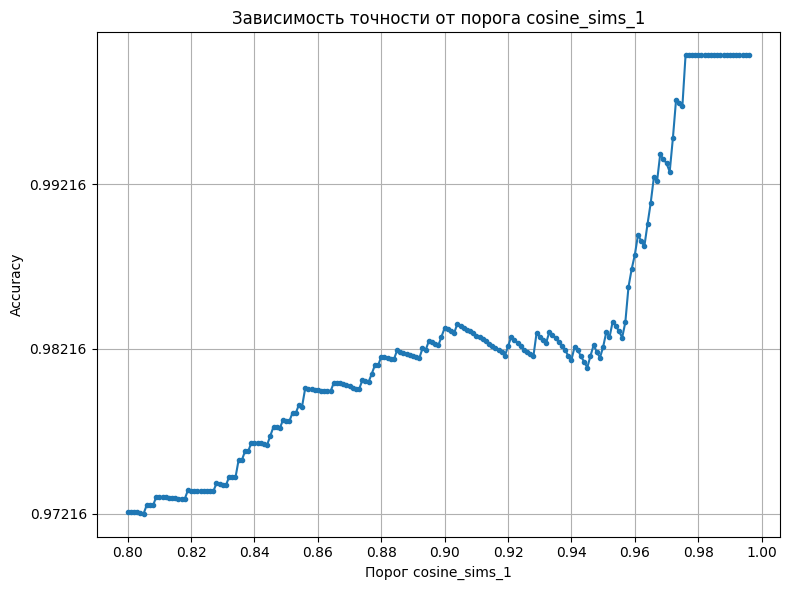

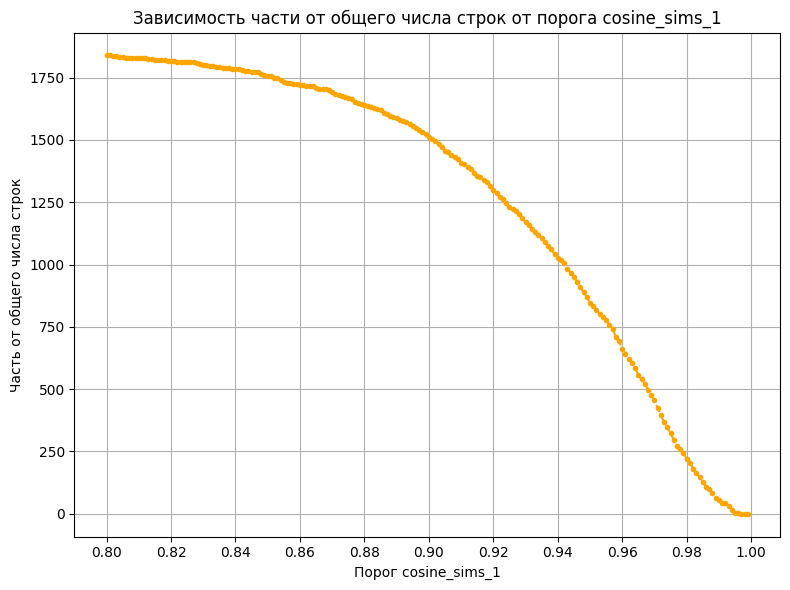

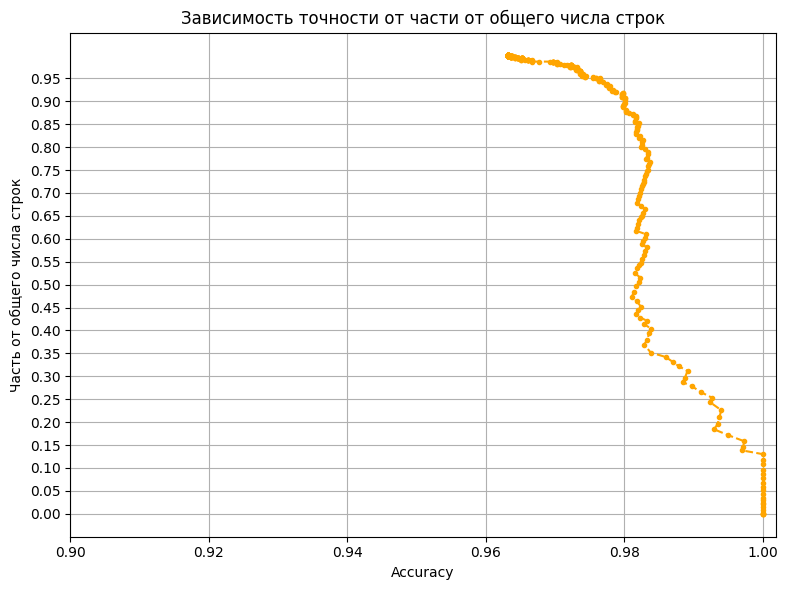

In [14]:
def accuracies_part(accuracies, part, x_start=0, x_stop=1.001, x_step=0.025):
    """
    Визуализирует зависимость точности и части от общего числа строк 
    на одном графике.

    Параметры:
    - accuracies: список значений точности
    - part: список значений части от общего числа строк
    """
    filtered_accuracies = [t for t in accuracies if t >= x_start]
    filtered_part = part[len(part) - len(filtered_accuracies):]
    plt.figure(figsize=(8, 6))

    plt.plot(filtered_accuracies, filtered_part, marker='.', color='orange', linestyle='dashed', label='Accuracy vs. Part')
    plt.title('Зависимость точности от части от общего числа строк')
    plt.xlabel('Accuracy')
    plt.ylabel('Часть от общего числа строк')
    plt.grid(True)

    plt.yticks(np.arange(min(filtered_part), max(filtered_part), 0.05))
    plt.xticks(np.arange(x_start, x_stop, x_step))

    plt.tight_layout()
    plt.show()

plot_threshold_accuracies(thresholds, accuracies, x_start=0.8, x_stop=1.001, x_step=0.02, y_step=0.01)
plot_threshold_part(thresholds, part, x_start=0.8, x_stop=1.001, x_step=0.02)
accuracies_part(accuracies, [i/len(df_offers) for i in part], x_start=0.9, x_stop=1.001, x_step=0.02)

In [15]:
df_thersold

,name,model_id,offer_id,modelized_by_barcode,category_name,category_id,price,attrs,description,external_category,...,model_id_pred_1,cosine_sims_1,model_id_pred_2,cosine_sims_2,model_id_pred_3,cosine_sims_3,model_id_pred_4,cosine_sims_4,model_id_pred_5,cosine_sims_5


In [16]:
accurate_predictions_threshold

0

In [17]:
def emb_to_df(df, embs):
    embed_name = []
    for index, row in df.iterrows():
        embed_name.append(embs[index])
    return embed_name

def calc_acc_for_category(df_offers, df_models, imya_kategorii, models_embs, offers_embs):
    print(f"{imya_kategorii}")
    start_time = time.time()
    df_offers = df_offers[df_offers.category_name == imya_kategorii]
    df_models = df_models[df_models.category_name == imya_kategorii]

    offer_embs = emb_to_df(df_offers, offers_embs)
    offer_model_id = list(df_offers['model_id'])

    model_embs = emb_to_df(df_models, models_embs)
    model_model_id = list(df_models['model_id'])

    print(f"\tофферов {len(offer_embs)} шт поиск матча для каждого среди {len(model_model_id)} шт моделей")

    batch_size = max((1, (5000*4000)//len(model_model_id)))
    top_n = top_n_similar(offer_embs, model_embs, model_model_id, batch_size, n=5)
    offer_model_id_predicted = [i['model_ids'][0] for i in top_n]

    equal = np.sum(np.array(offer_model_id) == np.array(offer_model_id_predicted))
    accuracy = round(100*equal/len(offer_model_id), 2)
    print(f"\taccuracy = {accuracy}%\n\ttime_spent = {round(time.time() - start_time, 2)} sec\n")
    return accuracy


accuracy_one_model = []
for category in id_category.values():
    accuracy = calc_acc_for_category(df_offers, df_models, category, model_embs, offer_embs)
    accuracy_one_model.append(accuracy)

мобильные телефоны
	офферов 1876 шт поиск матча для каждого среди 770 шт моделей
	accuracy = 96.32%
	time_spent = 0.43 sec

